In [65]:
import glob
import re
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
import torch

In [41]:
file_list = glob.glob("./data/*.bmp")

In [42]:
img_list = []
img_labels = []
for filename in file_list:
    filename_file = re.search("s[0-9]{1,3}.bmp", filename)[0]
    filename_order = re.search("[0-9]{1,3}", filename_file)[0]
#     print(filename_order)
    img_labels.append(filename_order)
    img = cv2.imread(filename)
    img_list.append(img)

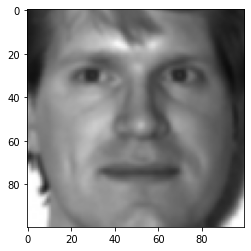

In [43]:
plt.imshow(img_list[0])

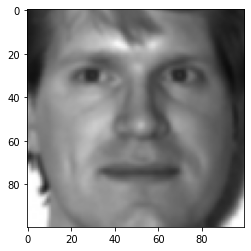

In [67]:
imgDir = './data/'
img_list = []
img_labels = []
for i in range(1, 166):
    fileName = 's' + str(i) + '.bmp'
    img = cv2.imread(imgDir + fileName)
    img_list.append(img)
    img_labels.append((i - 1) // 11)

plt.imshow(img_list[0])

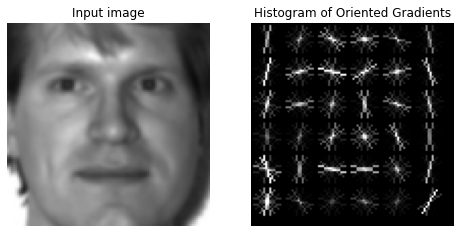

In [68]:
image = img_list[0]
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), block_norm='L2-Hys',
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
# plt.savefig('./hog.jpg')
plt.show()

In [69]:
# 提取数据的HOG特征

hog_func = lambda x:hog(x, orientations=8, pixels_per_cell=(16, 16), block_norm='L2-Hys',
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
X_hog = np.array([hog_func(img)[0] for img in img_list])
y = np.array(img_labels)
print(X_hog.shape)
print(y.shape)

(165, 288)
(165,)


In [70]:
# 将数据集划分为训练集、噪声集

X_noise = X_hog[12*11:, :]
y_noise = y[12*11:]
X_all = X_hog[:12*11, :]
y_all = y[:12*11]
print(X_all.shape)
print(y_all.shape)
print(X_noise.shape)
print(y_noise.shape)

(132, 288)
(132,)
(33, 288)
(33,)


In [74]:

model = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial')

if not os.path.exists("model"):
    os.mkdir("model")
    
if os.path.exists('model/noise3_hog_softmax_yale.h5'):
    print('loading model...')
    model = torch.load('model/noise3_hog_softmax_yale.h5');
    print('load model successful!')
else:
    print('traing model...')
    rkf = RepeatedKFold(n_splits=4, n_repeats=6, random_state=0)

    for i_train, i_test in rkf.split(X_all):
        model.fit(X_all[i_train], y_all[i_train])
    torch.save(model, "model/noise3_hog_softmax_yale.h5")
    print('train model successful!')

traing model...
train model successful!


In [75]:
scores = model.score(X_all, y_all)
print("scores：{}".format(scores))

pro_min = np.min(np.max(model.predict_proba(X_all), axis=1))
print("The minimum probability of all data corresponding to groundtruth：")
print(pro_min)

pred_noise = model.predict_proba(X_noise)
print("The maximum probability of noise data：")
print(np.max(pred_noise))

scores：1.0
The minimum probability of all data corresponding to groundtruth：
0.34974333777012573
The maximum probability of noise data：
0.32092408842239234


In [79]:
def Classfilter(clf, X, threshold = 0.33):
    if X.ndim == 1:
        X = X[np.newaxis, :]
    result = ''
    if (np.size(X, 0)  == 1 or np.size(X, 0) == 132): ti = 1
    else: ti = 133
    for i, x in enumerate(X):
        x = x[np.newaxis, :]
        pred_prob = clf.predict_proba(x)
        if (np.max(pred_prob) < threshold):
            result = result + 'Img {} is NOT IN the train dataset\n'.format(i+ti)
        else:
            y = np.argmax(pred_prob)
            result = result + 'Img {} is person: {}\n'.format(i+ti, y+1)
    print(result)

In [80]:
# 预测输出，输入数据为图像
def img_predict(clf, img):
    if img.ndim == 3:
        img = img[np.newaxis, :]
    X = hog_func(img);
    Classfilter(img)

In [81]:
Classfilter(model, X_all)

Img 1 is person: 1
Img 2 is person: 1
Img 3 is person: 1
Img 4 is person: 1
Img 5 is person: 1
Img 6 is person: 1
Img 7 is person: 1
Img 8 is person: 1
Img 9 is person: 1
Img 10 is person: 1
Img 11 is person: 1
Img 12 is person: 2
Img 13 is person: 2
Img 14 is person: 2
Img 15 is person: 2
Img 16 is person: 2
Img 17 is person: 2
Img 18 is person: 2
Img 19 is person: 2
Img 20 is person: 2
Img 21 is person: 2
Img 22 is person: 2
Img 23 is person: 3
Img 24 is person: 3
Img 25 is person: 3
Img 26 is person: 3
Img 27 is person: 3
Img 28 is person: 3
Img 29 is person: 3
Img 30 is person: 3
Img 31 is person: 3
Img 32 is person: 3
Img 33 is person: 3
Img 34 is person: 4
Img 35 is person: 4
Img 36 is person: 4
Img 37 is person: 4
Img 38 is person: 4
Img 39 is person: 4
Img 40 is person: 4
Img 41 is person: 4
Img 42 is person: 4
Img 43 is person: 4
Img 44 is person: 4
Img 45 is person: 5
Img 46 is person: 5
Img 47 is person: 5
Img 48 is person: 5
Img 49 is person: 5
Img 50 is person: 5
Img 51 is

In [82]:
# 搜索最优阈值
for i in range(2, 10):
    for j in range(1, 10):
        clf = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial')
        rkf = RepeatedKFold(n_splits=i, n_repeats=j, random_state=0)
        
        for i_train, i_test in rkf.split(X_all):
            clf.fit(X_all[i_train], y_all[i_train])
        
        scores = clf.score(X_all, y_all)
        print(i,j)
        print("scores：{}".format(scores))
        
        pro_min = np.min(np.max(clf.predict_proba(X_all), axis=1))
        print(pro_min)
        
        pred_noise = clf.predict_proba(X_noise)
        print(np.max(pred_noise))

2 1
scores：0.9848484848484849
0.21411323732117352
0.292597938959626
2 2
scores：0.9848484848484849
0.17628704663912123
0.2831434380703981
2 3
scores：0.9621212121212122
0.14751473989050443
0.3069729399413921
2 4
scores：0.946969696969697
0.1479159222452496
0.3917675946500262
2 5
scores：0.9924242424242424
0.17367352600613184
0.3466563870695196
2 6
scores：0.9924242424242424
0.2270514075272665
0.33386482540309204
2 7
scores：0.9848484848484849
0.14590588198755436
0.31948413440431134
2 8
scores：0.9621212121212122
0.1781097316017001
0.3650667444169859
2 9
scores：0.9696969696969697
0.18467034259197276
0.28884976193341444
3 1
scores：0.9848484848484849
0.219363045079392
0.28875692007140313
3 2
scores：1.0
0.16786622696520437
0.29376568003571585
3 3
scores：0.9924242424242424
0.1650578311239028
0.31808346193925796
3 4
scores：0.9924242424242424
0.17677233927225083
0.37038890208855496
3 5
scores：0.9924242424242424
0.18943616157027934
0.3043702543347891
3 6
scores：1.0
0.3258677624036298
0.32606617725761

d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4 9
scores：1.0
0.2517589754215077
0.3505115441515258
5 1
scores：1.0
0.27031792052812637
0.2938171474414609
5 2
scores：1.0
0.23784607302139854
0.3889548080106084
5 3
scores：1.0
0.17824499068071684
0.351798774750313
5 4
scores：1.0
0.21871095748210576
0.3379649607731699
5 5
scores：0.9924242424242424
0.24399299733576565
0.36861706790389653
5 6
scores：1.0
0.3485857612814986
0.3634972269133441


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 7
scores：1.0
0.24531904858188647
0.37384806853744196


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 8
scores：0.9924242424242424
0.30073355074116215
0.34992917777476246


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 9
scores：1.0
0.3401501843480101
0.3687323225052652
6 1
scores：1.0
0.2658517843073956
0.305832117721605
6 2
scores：1.0
0.23959316751649057
0.38478770584927824
6 3
scores：1.0
0.26687067582392604
0.37237772911713546
6 4
scores：1.0
0.21838636331060246
0.33349555583124074
6 5
scores：0.9924242424242424
0.23838926544294484
0.37040735843357103
6 6
scores：1.0
0.3217666974075505
0.3625978460189878
6 7
scores：1.0
0.24349524963356686
0.3735117950820751
6 8
scores：1.0
0.38998663400578054
0.34966600396446723
6 9
scores：1.0
0.3524276729160469
0.3641374658166243
7 1
scores：1.0
0.2668702737654989
0.30685906554401027
7 2
scores：1.0
0.26874016929436617
0.37785955294800133


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 3
scores：1.0
0.26347076407165404
0.372823597628355


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 4
scores：1.0
0.2199694221575095
0.3319952758234619


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 5
scores：0.9924242424242424
0.2368200981566249
0.36639302607479757


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 6
scores：1.0
0.31162468533214216
0.3590813355338036


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 7
scores：1.0
0.24395688920612607
0.3645969502911718


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 8
scores：1.0
0.38911413504448145
0.3452455628839075


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 9
scores：1.0
0.3859895469409551
0.3687176315387692
8 1
scores：1.0
0.29739902247524014
0.30164066587407784
8 2
scores：1.0
0.27398095860012034
0.3790272217002951
8 3
scores：1.0
0.2627110740453139
0.36950138787648673
8 4
scores：1.0
0.22039617677601997
0.3337344955832491


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8 5
scores：0.9924242424242424
0.23745314044028631
0.36650281573286897


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8 6
scores：1.0
0.3117828873053959
0.3598587100516162


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8 7
scores：1.0
0.2434876224355487
0.3651181835828668


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8 8
scores：1.0
0.38812164097738
0.35623006020084697


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8 9
scores：1.0
0.3852633793699554
0.3664327451455554
9 1
scores：1.0
0.29050295601155857
0.3046082404545429
9 2
scores：1.0
0.2739780965098992
0.3731987831027043
9 3
scores：1.0
0.26204710006923165
0.36706271833742105
9 4
scores：1.0
0.22056126165021747
0.3327735847378096
9 5
scores：0.9924242424242424
0.23691899020376367
0.365387738766201
9 6
scores：1.0
0.31370082411747996
0.351988345560683
9 7
scores：1.0
0.24223386092813307
0.3650170662323469


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


9 8
scores：1.0
0.3883323968861226
0.35496286388200626


d:\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


9 9
scores：1.0
0.43092452147243004
0.3594261442916626
